In [ ]:
!pip install hmmlearn
!pip install edhsmm

     |████████████████████████████████| 129 kB 6.8 MB/s 
     |████████████████████████████████| 127 kB 8.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for edhsmm: filename=edhsmm-0.2.1-cp37-cp37m-linux_x86_64.whl size=306231 sha256=357307e00fcc537cf629755b37f034c049d526859f59ec20bc4edb47d3093c22
  Stored in directory: /root/.cache/pip/wheels/7f/70/9c/2132c1aa7f962096fe38bc5e688db87b7379617eef6b358923
Successfully built edhsmm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/COS513')

Mounted at /content/drive


In [ ]:
import numpy as np
import sparse_jump as sj
from hmmlearn import hmm
import modified_jump as mj
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from edhsmm.hsmm_base import GaussianHSMM

# 2 states

In [ ]:
np.random.seed(1234)
model = hmm.GaussianHMM(n_components=2, covariance_type="full")
model.startprob_ = np.array([0.6, 0.4])
model.transmat_ = np.array([[0.995, 0.005],
                            [0.002, 0.998]])
model.means_ = np.array([[0.0, 0.0], [0.4, -0.4]])
model.covars_ = np.tile(np.identity(2), (2, 1, 1))
seq_length = 1000

In [ ]:
def get_BAC(real,pred):
  if np.count_nonzero(pred - real) > np.count_nonzero(1 - pred - real):
    pred = 1 - pred
  tp1 = np.count_nonzero(pred & real)
  fn1 = np.count_nonzero((1- pred) & real)
  tp0 = np.count_nonzero((1- pred) & (1 - real))
  fn0 = np.count_nonzero(pred & (1 - real))
  if (tp0 + fn0) == 0:
    return tp1/(tp1 + fn1)
  elif (tp1 + fn1) == 0:
    return tp0/(tp0 + fn0)
  else:
    return 0.5*( tp1/(tp1 + fn1) +  tp0/(tp0 + fn0) )

a = np.array([1,1,1,1,1])
b = np.array([1,1,1,1,1])
print(get_BAC(a,b))

1.0


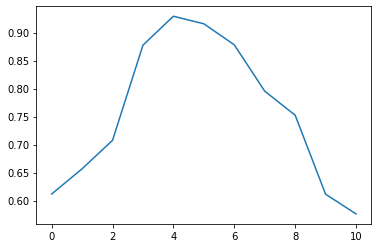

In [ ]:
n_fit = 100

# search the jump penalty parameter
n_para_jump = 11
jump_min = 0
jump_max = 2
jump = [np.power(10, jump_min + i * (jump_max - jump_min)/(n_para_jump - 1)) for i in range(n_para_jump)]

BAC_jump = np.zeros(n_para_jump)
for i in range(n_para_jump):
  saveBAC = np.zeros(n_fit)
  for j in range(n_fit):
    X, Z = model.sample(seq_length)
    Zsjump = sj.jump(X,2,jump_penalty=jump[i])
    saveBAC[j] = get_BAC(Z,Zsjump)
  BAC_jump[i] = saveBAC.mean()

plt.plot(BAC_jump)

In [ ]:
print(jump)
print(BAC_jump)

[1.0, 1.5848931924611136, 2.51188643150958, 3.9810717055349722, 6.309573444801933, 10.0, 15.848931924611133, 25.118864315095795, 39.810717055349734, 63.09573444801933, 100.0]
[0.6117693  0.65681509 0.70765075 0.87765448 0.92921423 0.91572191
 0.87818151 0.79541597 0.75250532 0.61145072 0.57623287]


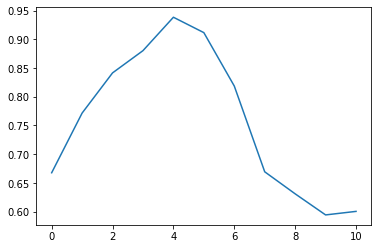

In [ ]:
n_fit = 100

# search the tune_loss parameter
n_para_loss = 11
loss_min = -1
loss_max = 1
loss = [np.power(10, loss_min + i * (loss_max - loss_min)/(n_para_loss - 1)) for i in range(n_para_loss)]

BAC_loss = np.zeros(n_para_loss)
for i in range(n_para_loss):
  saveBAC = np.zeros(n_fit)
  for j in range(n_fit):
    X, Z = model.sample(seq_length)
    Zmjump = mj.jump(X,2,jump_penalty=jump[4],tune_loss = loss[i])
    saveBAC[j] = get_BAC(Z,Zmjump)
  BAC_loss[i] = saveBAC.mean()

plt.plot(BAC_loss)

In [ ]:
print(loss)
print(BAC_loss)

[0.1, 0.15848931924611134, 0.251188643150958, 0.3981071705534972, 0.6309573444801934, 1.0, 1.5848931924611134, 2.5118864315095797, 3.981071705534973, 6.309573444801933, 10.0]
[0.66765919 0.77152927 0.841481   0.88022345 0.93836111 0.91156179
 0.81858833 0.66932904 0.63096204 0.59426478 0.60041598]


In [ ]:
# Test BAC
n_test = 100
jump_para = 6.309573444801933
loss_para = 0.6309573444801934

saveBAC = np.zeros((4, n_test))
for j in range(n_test):
  X, Z = model.sample(seq_length)
  remodel = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=100)
  remodel.fit(X)
  Zhmm = remodel.predict(X)
  Zk = KMeans(n_clusters=3, random_state=0).fit(X).labels_
  Zsjump = sj.jump(X,2,jump_penalty=jump_para)
  Zmjump = mj.jump(X,2,jump_penalty=jump_para,tune_loss = loss_para)
  saveBAC[0, j] = get_BAC(Z,Zhmm)
  saveBAC[1, j] = get_BAC(Z,Zk)
  saveBAC[2, j] = get_BAC(Z,Zsjump)
  saveBAC[3, j] = get_BAC(Z,Zmjump)

print(np.mean(saveBAC, axis = 1))

[0.66767401 0.56351284 0.91540762 0.91738251]


# 2 states - 2

In [ ]:
np.random.seed(1234)
model = hmm.GaussianHMM(n_components=2, covariance_type="full")
'''
model.startprob_ = np.array([0.6, 0.4])
model.transmat_ = np.array([[0.6, 0.4],
                            [0.35, 0.65]])
model.means_ = np.array([[0.0, 0.0], [0.2, -0.2]])
model.covars_ = np.tile(np.identity(2), (2, 1, 1))
'''
'''
model.startprob_ = np.array([0.6, 0.4])
model.transmat_ = np.array([[0.9, 0.1],
                            [0.4, 0.6]])
model.means_ = np.array([[0.0, 0.0], [0.5, -0.5]])
model.covars_ = np.tile(np.identity(2), (2, 1, 1))
'''
model.startprob_ = np.array([0.6, 0.4])
model.transmat_ = np.array([[0.9, 0.1],
                            [0.3, 0.7]])
model.means_ = np.array([[0.0, 0.0], [1, -1]])
model.covars_ = np.array([np.diag([1,1]), np.diag([2,1])])
seq_length = 1000

In [ ]:
def get_BAC(real,pred):
  if np.count_nonzero(pred - real) > np.count_nonzero(1 - pred - real):
    pred = 1 - pred
  tp1 = np.count_nonzero(pred & real)
  fn1 = np.count_nonzero((1- pred) & real)
  tp0 = np.count_nonzero((1- pred) & (1 - real))
  fn0 = np.count_nonzero(pred & (1 - real))
  if (tp0 + fn0) == 0:
    return tp1/(tp1 + fn1)
  elif (tp1 + fn1) == 0:
    return tp0/(tp0 + fn0)
  else:
    return 0.5*( tp1/(tp1 + fn1) +  tp0/(tp0 + fn0) )

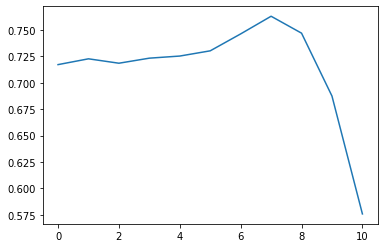

In [ ]:
n_fit = 100

# search the jump penalty parameter
n_para_jump = 11
jump_min = -2
jump_max = 1
jump = [np.power(10, jump_min + i * (jump_max - jump_min)/(n_para_jump - 1)) for i in range(n_para_jump)]

BAC_jump = np.zeros(n_para_jump)
for i in range(n_para_jump):
  saveBAC = np.zeros(n_fit)
  for j in range(n_fit):
    X, Z = model.sample(seq_length)
    Zsjump = sj.jump(X,2,jump_penalty=jump[i])
    saveBAC[j] = get_BAC(Z,Zsjump)
  BAC_jump[i] = saveBAC.mean()

plt.plot(BAC_jump)

In [ ]:
print(jump)
print(BAC_jump)

[0.01, 0.0199526231496888, 0.039810717055349734, 0.07943282347242814, 0.15848931924611134, 0.31622776601683794, 0.6309573444801934, 1.2589254117941675, 2.5118864315095797, 5.011872336272725, 10.0]
[0.71724425 0.72273699 0.71856683 0.72335228 0.7253545  0.73029977
 0.74632452 0.7630467  0.74703132 0.68748307 0.57587993]


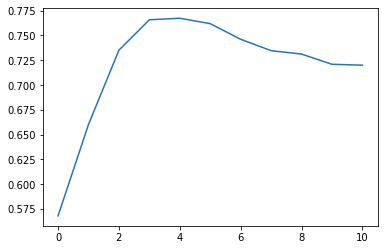

In [ ]:
n_fit = 100

# search the tune_loss parameter
n_para_loss = 11
loss_min = -1
loss_max = 1
loss = [np.power(10, loss_min + i * (loss_max - loss_min)/(n_para_loss - 1)) for i in range(n_para_loss)]

BAC_loss = np.zeros(n_para_loss)
for i in range(n_para_loss):
  saveBAC = np.zeros(n_fit)
  for j in range(n_fit):
    X, Z = model.sample(seq_length)
    Zmjump = mj.jump(X,2,jump_penalty=jump[7],tune_loss = loss[i])
    saveBAC[j] = get_BAC(Z,Zmjump)
  BAC_loss[i] = saveBAC.mean()

plt.plot(BAC_loss)

In [ ]:
print(loss)
print(BAC_loss)

[0.1, 0.15848931924611134, 0.251188643150958, 0.3981071705534972, 0.6309573444801934, 1.0, 1.5848931924611134, 2.5118864315095797, 3.981071705534973, 6.309573444801933, 10.0]
[0.56798674 0.66020953 0.73514884 0.76579816 0.76737894 0.76191751
 0.74617351 0.73466324 0.73124632 0.720952   0.72000868]


In [ ]:
# Test BAC
n_test = 100
jump_para = 1.2589254117941675
loss_para = 0.6309573444801934

saveBAC = np.zeros((4, n_test))
for j in range(n_test):
  X, Z = model.sample(seq_length)
  remodel = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=100)
  remodel.fit(X)
  Zhmm = remodel.predict(X)
  Zk = KMeans(n_clusters=3, random_state=0).fit(X).labels_
  Zsjump = sj.jump(X,2,jump_penalty=jump_para)
  Zmjump = mj.jump(X,2,jump_penalty=jump_para,tune_loss = loss_para)
  saveBAC[0, j] = get_BAC(Z,Zhmm)
  saveBAC[1, j] = get_BAC(Z,Zk)
  saveBAC[2, j] = get_BAC(Z,Zsjump)
  saveBAC[3, j] = get_BAC(Z,Zmjump)

print(np.mean(saveBAC, axis = 1))

[0.76051353 0.63109674 0.75928416 0.76722667]


# 2 states - 3

In [ ]:
np.random.seed(1234)
model = hmm.GaussianHMM(n_components=2, covariance_type="full")
model.startprob_ = np.array([0.6, 0.4])
model.transmat_ = np.array([[0.8, 0.2],
                            [0.3, 0.7]])
model.means_ = np.array([[0.0, 0.0], [2, -2]])
model.covars_ = np.tile(np.identity(2), (2, 1, 1))
seq_length = 1000

In [ ]:
def get_BAC(real,pred):
  if np.count_nonzero(pred - real) > np.count_nonzero(1 - pred - real):
    pred = 1 - pred
  tp1 = np.count_nonzero(pred & real)
  fn1 = np.count_nonzero((1- pred) & real)
  tp0 = np.count_nonzero((1- pred) & (1 - real))
  fn0 = np.count_nonzero(pred & (1 - real))
  if (tp0 + fn0) == 0:
    return tp1/(tp1 + fn1)
  elif (tp1 + fn1) == 0:
    return tp0/(tp0 + fn0)
  else:
    return 0.5*( tp1/(tp1 + fn1) +  tp0/(tp0 + fn0) )

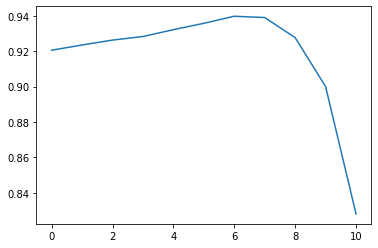

In [ ]:
n_fit = 100

# search the jump penalty parameter
n_para_jump = 11
jump_min = -1
jump_max = 1
jump = [np.power(10, jump_min + i * (jump_max - jump_min)/(n_para_jump - 1)) for i in range(n_para_jump)]

BAC_jump = np.zeros(n_para_jump)
for i in range(n_para_jump):
  saveBAC = np.zeros(n_fit)
  for j in range(n_fit):
    X, Z = model.sample(seq_length)
    Zsjump = sj.jump(X,2,jump_penalty=jump[i])
    saveBAC[j] = get_BAC(Z,Zsjump)
  BAC_jump[i] = saveBAC.mean()

plt.plot(BAC_jump)

In [ ]:
print(jump)
print(BAC_jump)

[0.1, 0.15848931924611134, 0.251188643150958, 0.3981071705534972, 0.6309573444801934, 1.0, 1.5848931924611134, 2.5118864315095797, 3.981071705534973, 6.309573444801933, 10.0]
[0.92060612 0.92353194 0.9263147  0.92834477 0.93221475 0.93580571
 0.9397998  0.93906423 0.92769872 0.90003573 0.82802   ]


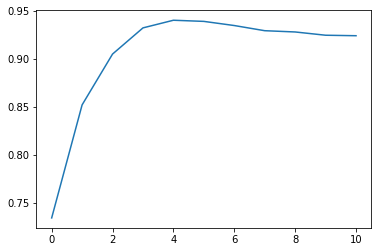

In [ ]:
n_fit = 100

# search the tune_loss parameter
n_para_loss = 11
loss_min = -1
loss_max = 1
loss = [np.power(10, loss_min + i * (loss_max - loss_min)/(n_para_loss - 1)) for i in range(n_para_loss)]

BAC_loss = np.zeros(n_para_loss)
for i in range(n_para_loss):
  saveBAC = np.zeros(n_fit)
  for j in range(n_fit):
    X, Z = model.sample(seq_length)
    Zmjump = mj.jump(X,2,jump_penalty=jump[6],tune_loss = loss[i])
    saveBAC[j] = get_BAC(Z,Zmjump)
  BAC_loss[i] = saveBAC.mean()

plt.plot(BAC_loss)

In [ ]:
print(loss)
print(BAC_loss)

[0.1, 0.15848931924611134, 0.251188643150958, 0.3981071705534972, 0.6309573444801934, 1.0, 1.5848931924611134, 2.5118864315095797, 3.981071705534973, 6.309573444801933, 10.0]
[0.73431711 0.85216302 0.90514637 0.93243953 0.94040412 0.93921197
 0.93488543 0.92950243 0.92818355 0.92477937 0.92426528]


In [ ]:
# Test BAC
n_test = 100
jump_para = 1.5848931924611134
loss_para = 0.6309573444801934

saveBAC = np.zeros((4, n_test))
for j in range(n_test):
  X, Z = model.sample(seq_length)
  remodel = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=100)
  remodel.fit(X)
  Zhmm = remodel.predict(X)
  Zk = KMeans(n_clusters=3, random_state=0).fit(X).labels_
  Zsjump = sj.jump(X,2,jump_penalty=jump_para)
  Zmjump = mj.jump(X,2,jump_penalty=jump_para,tune_loss = loss_para)
  saveBAC[0, j] = get_BAC(Z,Zhmm)
  saveBAC[1, j] = get_BAC(Z,Zk)
  saveBAC[2, j] = get_BAC(Z,Zsjump)
  saveBAC[3, j] = get_BAC(Z,Zmjump)

print(np.mean(saveBAC, axis = 1))

[0.93643032 0.79156132 0.93865686 0.93892402]


# 2 states - 4

In [ ]:
np.random.seed(1234)
model = hmm.GaussianHMM(n_components=2, covariance_type="full")
'''
model.startprob_ = np.array([0.6, 0.4])
model.transmat_ = np.array([[0.6, 0.4],
                            [0.35, 0.65]])
model.means_ = np.array([[0.0, 0.0], [0.2, -0.2]])
model.covars_ = np.tile(np.identity(2), (2, 1, 1))
'''
'''
model.startprob_ = np.array([0.6, 0.4])
model.transmat_ = np.array([[0.9, 0.1],
                            [0.4, 0.6]])
model.means_ = np.array([[0.0, 0.0], [0.5, -0.5]])
model.covars_ = np.tile(np.identity(2), (2, 1, 1))
'''
model.startprob_ = np.array([0.6, 0.4])
model.transmat_ = np.array([[0.9, 0.1],
                            [0.5, 0.5]])
model.means_ = np.array([[0.0, 0.0], [0.5, -0.5]])
model.covars_ = np.tile(np.identity(2), (2, 1, 1))
seq_length = 1000

In [ ]:
def get_BAC(real,pred):
  if np.count_nonzero(pred - real) > np.count_nonzero(1 - pred - real):
    pred = 1 - pred
  tp1 = np.count_nonzero(pred & real)
  fn1 = np.count_nonzero((1- pred) & real)
  tp0 = np.count_nonzero((1- pred) & (1 - real))
  fn0 = np.count_nonzero(pred & (1 - real))
  if (tp0 + fn0) == 0:
    return tp1/(tp1 + fn1)
  elif (tp1 + fn1) == 0:
    return tp0/(tp0 + fn0)
  else:
    return 0.5*( tp1/(tp1 + fn1) +  tp0/(tp0 + fn0) )

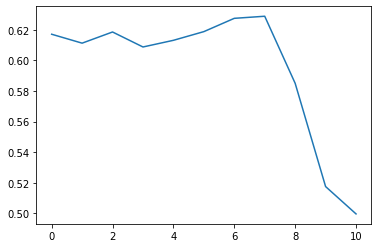

In [ ]:
n_fit = 100

# search the jump penalty parameter
n_para_jump = 11
jump_min = -3
jump_max = 1
jump = [np.power(10, jump_min + i * (jump_max - jump_min)/(n_para_jump - 1)) for i in range(n_para_jump)]

BAC_jump = np.zeros(n_para_jump)
for i in range(n_para_jump):
  saveBAC = np.zeros(n_fit)
  for j in range(n_fit):
    X, Z = model.sample(seq_length)
    Zsjump = sj.jump(X,2,jump_penalty=jump[i])
    saveBAC[j] = get_BAC(Z,Zsjump)
  BAC_jump[i] = saveBAC.mean()

plt.plot(BAC_jump)

In [ ]:
print(jump)
print(BAC_jump)

[0.001, 0.0025118864315095794, 0.00630957344480193, 0.015848931924611134, 0.039810717055349734, 0.1, 0.25118864315095796, 0.630957344480193, 1.584893192461114, 3.981071705534973, 10.0]
[0.61709331 0.61126003 0.61856388 0.60876015 0.61311941 0.61879917
 0.62749424 0.6288586  0.58500574 0.51748889 0.4995987 ]


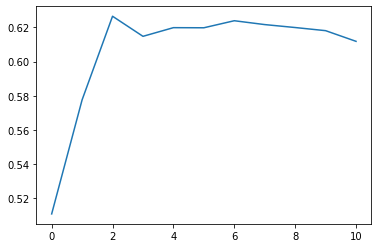

In [ ]:
n_fit = 100

# search the tune_loss parameter
n_para_loss = 11
loss_min = -1
loss_max = 3
loss = [np.power(10, loss_min + i * (loss_max - loss_min)/(n_para_loss - 1)) for i in range(n_para_loss)]

BAC_loss = np.zeros(n_para_loss)
for i in range(n_para_loss):
  saveBAC = np.zeros(n_fit)
  for j in range(n_fit):
    X, Z = model.sample(seq_length)
    Zmjump = mj.jump(X,2,jump_penalty=jump[7],tune_loss = loss[i])
    saveBAC[j] = get_BAC(Z,Zmjump)
  BAC_loss[i] = saveBAC.mean()

plt.plot(BAC_loss)

In [ ]:
print(loss)
print(BAC_loss)

[0.1, 0.251188643150958, 0.6309573444801934, 1.5848931924611134, 3.981071705534973, 10.0, 25.118864315095795, 63.0957344480193, 158.48931924611142, 398.1071705534973, 1000.0]
[0.5108095  0.57760403 0.62655596 0.61479501 0.61986884 0.6198025
 0.62392867 0.62167169 0.61994632 0.61811323 0.6118626 ]


In [ ]:
# Test BAC
n_test = 100
jump_para = 0.630957344480193
loss_para = 0.6309573444801934

saveBAC = np.zeros((4, n_test))
for j in range(n_test):
  X, Z = model.sample(seq_length)
  remodel = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=100)
  remodel.fit(X)
  Zhmm = remodel.predict(X)
  Zk = KMeans(n_clusters=3, random_state=0).fit(X).labels_
  Zsjump = sj.jump(X,2,jump_penalty=jump_para)
  Zmjump = mj.jump(X,2,jump_penalty=jump_para,tune_loss = loss_para)
  saveBAC[0, j] = get_BAC(Z,Zhmm)
  saveBAC[1, j] = get_BAC(Z,Zk)
  saveBAC[2, j] = get_BAC(Z,Zsjump)
  saveBAC[3, j] = get_BAC(Z,Zmjump)

print(np.mean(saveBAC, axis = 1))

[0.60679156 0.57064297 0.61636376 0.61785702]


# 2 states - 5

In [ ]:
np.random.seed(1234)
model = hmm.GaussianHMM(n_components=2, covariance_type="full")
'''
model.startprob_ = np.array([0.6, 0.4])
model.transmat_ = np.array([[0.6, 0.4],
                            [0.35, 0.65]])
model.means_ = np.array([[0.0, 0.0], [0.2, -0.2]])
model.covars_ = np.tile(np.identity(2), (2, 1, 1))
'''
'''
model.startprob_ = np.array([0.6, 0.4])
model.transmat_ = np.array([[0.9, 0.1],
                            [0.4, 0.6]])
model.means_ = np.array([[0.0, 0.0], [0.5, -0.5]])
model.covars_ = np.tile(np.identity(2), (2, 1, 1))
'''
model.startprob_ = np.array([0.6, 0.4])
model.transmat_ = np.array([[0.8, 0.2],
                            [0.3, 0.7]])
model.means_ = np.array([[0.0, 0.0], [1, -1]])
model.covars_ = np.array([np.diag([1,1]), np.diag([2,2])])
seq_length = 1000

In [ ]:
def get_BAC(real,pred):
  if np.count_nonzero(pred - real) > np.count_nonzero(1 - pred - real):
    pred = 1 - pred
  tp1 = np.count_nonzero(pred & real)
  fn1 = np.count_nonzero((1- pred) & real)
  tp0 = np.count_nonzero((1- pred) & (1 - real))
  fn0 = np.count_nonzero(pred & (1 - real))
  if (tp0 + fn0) == 0:
    return tp1/(tp1 + fn1)
  elif (tp1 + fn1) == 0:
    return tp0/(tp0 + fn0)
  else:
    return 0.5*( tp1/(tp1 + fn1) +  tp0/(tp0 + fn0) )

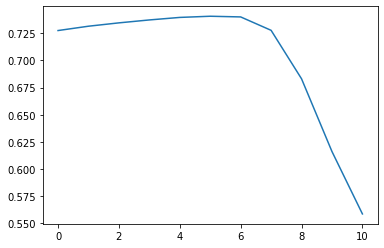

In [ ]:
n_fit = 100

# search the jump penalty parameter
n_para_jump = 11
jump_min = -1
jump_max = 1
jump = [np.power(10, jump_min + i * (jump_max - jump_min)/(n_para_jump - 1)) for i in range(n_para_jump)]

BAC_jump = np.zeros(n_para_jump)
for i in range(n_para_jump):
  saveBAC = np.zeros(n_fit)
  for j in range(n_fit):
    X, Z = model.sample(seq_length)
    Zsjump = sj.jump(X,2,jump_penalty=jump[i])
    saveBAC[j] = get_BAC(Z,Zsjump)
  BAC_jump[i] = saveBAC.mean()

plt.plot(BAC_jump)

In [ ]:
print(jump)
print(BAC_jump)

[0.1, 0.15848931924611134, 0.251188643150958, 0.3981071705534972, 0.6309573444801934, 1.0, 1.5848931924611134, 2.5118864315095797, 3.981071705534973, 6.309573444801933, 10.0]
[0.72756838 0.73156577 0.73464956 0.73734138 0.73966733 0.74075015
 0.74012572 0.72777241 0.6830935  0.61604626 0.55853984]


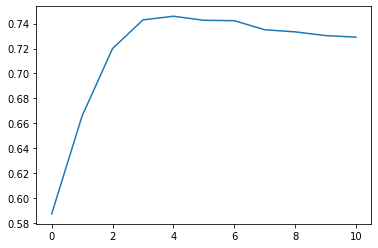

In [ ]:
n_fit = 100

# search the tune_loss parameter
n_para_loss = 11
loss_min = -1
loss_max = 1
loss = [np.power(10, loss_min + i * (loss_max - loss_min)/(n_para_loss - 1)) for i in range(n_para_loss)]

BAC_loss = np.zeros(n_para_loss)
for i in range(n_para_loss):
  saveBAC = np.zeros(n_fit)
  for j in range(n_fit):
    X, Z = model.sample(seq_length)
    Zmjump = mj.jump(X,2,jump_penalty=jump[5],tune_loss = loss[i])
    saveBAC[j] = get_BAC(Z,Zmjump)
  BAC_loss[i] = saveBAC.mean()

plt.plot(BAC_loss)

In [ ]:
print(loss)
print(BAC_loss)

[0.1, 0.15848931924611134, 0.251188643150958, 0.3981071705534972, 0.6309573444801934, 1.0, 1.5848931924611134, 2.5118864315095797, 3.981071705534973, 6.309573444801933, 10.0]
[0.58740152 0.66596342 0.71999616 0.74298932 0.74590982 0.74266484
 0.74233898 0.73507078 0.73338704 0.73040652 0.72913858]


In [ ]:
# Test BAC
n_test = 100
jump_para = 1.0
loss_para = 0.6309573444801934

saveBAC = np.zeros((4, n_test))
for j in range(n_test):
  X, Z = model.sample(seq_length)
  remodel = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=100)
  remodel.fit(X)
  Zhmm = remodel.predict(X)
  Zk = KMeans(n_clusters=3, random_state=0).fit(X).labels_
  Zsjump = sj.jump(X,2,jump_penalty=jump_para)
  Zmjump = mj.jump(X,2,jump_penalty=jump_para,tune_loss = loss_para)
  saveBAC[0, j] = get_BAC(Z,Zhmm)
  saveBAC[1, j] = get_BAC(Z,Zk)
  saveBAC[2, j] = get_BAC(Z,Zsjump)
  saveBAC[3, j] = get_BAC(Z,Zmjump)

print(np.mean(saveBAC, axis = 1))

[0.75945163 0.63501766 0.74306746 0.74567842]
